In [1]:
import argparse
parser = argparse.ArgumentParser(prog = 'Run Model')
parser.add_argument('--WalkerID', type=int, choices=range(10000), default=0)
parser.add_argument('--uv_filepath', type=str, default='uv_final.npy')
parser.add_argument('--saving_location', type=str, default='')
parser.add_argument('--averages_fstring', type=str, default='averages_{}_float32.npy')
parser.add_argument('--BoxesPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/LightConeBoxes")
parser.add_argument('--ParametersPath', type=str, default="/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/GridPositions")
parser.add_argument('--depth_mhz', type=int, default = 0) # if depth==0 calculate it from cube, else fix it to given value
# parser.add_argument('--uv_treshold', type=int, default = 1) # taking in account only baselines which were visited uv_treshold amount of times 
parser.add_argument('--SKA_observation_time', type=int, default = 1000)
inputs = parser.parse_args("--WalkerID 9999 --uv_filepath ../data/uv_Steven.npy --saving_location ../DatabaseTest --BoxesPath ../DatabaseTest --averages_fstring ../DatabaseTest/averages_{}_float32.npy".split(" "))

import numpy as np
import sys
import os
from src.py21cnn.database import DatabaseUtils
from src.py21cnn.formatting import Filters
import json

import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

#define path to database, send to program as parameters if different from default
Redshifts = ['006.00060', '006.75589', '007.63960', '008.68274', '009.92624', '011.42503', \
            '013.25424', '015.51874', '018.36856', '022.02434', '026.82138', '033.28927', '034.50984']
Parameters = ["ZETA", "TVIR_MIN", "L_X", "NU_X_THRESH"]
database = DatabaseUtils.Database(Parameters, Redshifts, inputs.BoxesPath, inputs.ParametersPath)
deltaTmin = -250
deltaTmax = 50
Zmax = 30

print("loading lightcone")
Box = database.CombineBoxes(inputs.WalkerID)
print("removing large Z")
Box = Filters.RemoveLargeZ(Box, database, Z=Zmax)
print("removing NaNs")
np.nan_to_num(Box, copy=False, nan=deltaTmin, posinf=deltaTmax, neginf=deltaTmin)
print("clipping large values")
np.clip(Box, deltaTmin, deltaTmax, out=Box)

BoxAverage = np.load(inputs.averages_fstring.format(inputs.WalkerID))
print("removing large Z for average")
BoxAverage = Filters.RemoveLargeZ(BoxAverage, database, Z=Zmax)

Box -= BoxAverage

loading lightcone
removing large Z
removing NaNs
clipping large values
removing large Z for average


In [2]:
import tools21cm as t2c
N_ant = 512 #or 513?

t2c.const.set_hubble_h(0.678)
t2c.const.set_omega_matter(0.308)
t2c.const.set_omega_baryon(0.048425)
t2c.const.set_omega_lambda(0.692)
t2c.const.set_ns(0.968)
t2c.const.set_sigma_8(0.815)

d0 = t2c.cosmology.z_to_cdist(float(Redshifts[0]))
cdist = np.array(range(Box.shape[-1] + 1))*1.5 + d0
redshifts = t2c.cosmology.cdist_to_z(cdist)
redshifts_mean = (redshifts[:-1] + redshifts[1:]) / 2

In [3]:
def noise(Box, depth_mhz, uv, seed_index):
    finalBox = []
    for i in range(Box.shape[-1]):
        if depth_mhz == 0:
            depth_mhz = t2c.cosmology.z_to_nu(redshifts[i]) - t2c.cosmology.z_to_nu(redshifts[i+1])
        noise = t2c.noise_model.noise_map(ncells=200,
                                          z=redshifts_mean[i],
                                          depth_mhz=depth_mhz,
                                          obs_time=inputs.SKA_observation_time,
                                          boxsize=300, 
                                          uv_map=uv[..., i],
                                          N_ant=N_ant,
                                          seed = 1000000*i + 100*inputs.WalkerID + seed_index, #last index is noise number index
                                          ) # I've corrected the function so it returns noise in uv, not in real space
        noise = t2c.telescope_functions.jansky_2_kelvin(noise, redshifts_mean[i])
        finalBox.append(noise)
    finalBox = np.moveaxis(np.array(finalBox), 0, -1)
    finalBox[uv_bool] = 0
    return finalBox
def noise_n_signal(Box, depth_mhz, uv, seed_index):
    Noise = noise(Box, depth_mhz, uv, seed_index)
    return np.real(np.fft.ifft2(Box + Noise, axes=(0, 1)))

In [4]:
uv = np.load(inputs.uv_filepath)
uv_bool = (uv < 1)

Box = np.fft.fft2(Box, axes=(0, 1))
Box[uv_bool] = 0
Box = noise_n_signal(Box, 0, uv, seed_index = 0)

In [5]:
from scipy.integrate import quadrature

In [34]:
def one_over_E(z):
    return 1 / np.sqrt(t2c.const.Omega0*(1.+z)**3+t2c.const.lam)
def kappa(z, k_cube, b = 0):
    return np.sqrt(k_cube[0]**2 + k_cube[1]**2) * 1 / one_over_E(z) / (1+z) * quadrature(one_over_E, 0, z)[0] + b
def W(k_cube, z, b = 0):
    k_scaled = k_cube[2] / kappa(z, k_cube, b)
    return 1 - ((k_scaled >= -1.) * (k_scaled <= 1.)).astype(np.float32)

In [36]:
def simple_sliding():
    k_perp = np.fft.fftfreq(Box.shape[0], d=1.5)
    k_parallel = np.fft.fftfreq(Box.shape[-1], d=1.5)
    k_cube = np.meshgrid(k_perp, k_perp, k_parallel)
    
    Box_final = np.zeros(Box.shape)
    Box_inv = np.fft.fftn(Box)
    for i, z in enumerate(redshifts_mean):
        print(i, end=' ')
        Box_final[..., i] = np.real(np.fft.ifftn(Box_inv * W(k_cube, z))[..., i])
    return Box_final
def blackman_sliding(chunk_length = Box.shape[0]):
    chunk_length = chunk_length // 2 * 2
    k_perp = np.fft.fftfreq(Box.shape[0], d=1.5)
    k_parallel = np.fft.fftfreq(chunk_length, d=1.5)
    k_cube = np.meshgrid(k_perp, k_perp, k_parallel)
    
    Box_final = np.zeros(Box.shape)
    
    #beginning
    t_box = Box[..., :chunk_length]
    Box_final[..., :chunk_length//2] = np.fft.ifftn(np.fft.fftn(t_box * np.blackman(chunk_length)[np.newaxis, np.newaxis, :]) * W(k_cube, redshifts_mean[chunk_length-1]))[] 
    for i in len(redshifts_mean):
        if i< chunk_length // 2:
            continue
        elif i == chunk_length // 2:
            t_box = Box[..., i - chunk_length // 2: i + chunk_length // 2 + 1]
            Box_final[..., i - chunk_length // 2: i+1]

In [37]:
Box_final = simple_sliding()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [40]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
def plotting_wedge(Box_final):
    fig, ax =plt.subplots(2, 1, figsize=(25, 3*2))
    im = ax[0].imshow(Box[0], vmin = -1e2, vmax = 1e2)
    ax[0].set_xticks(np.array(range(9)) * 250)
    ax[0].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[0].set_yticks([])
    plt.colorbar(im, ax = ax[0], fraction=0.005, pad=0.005)
    ax[0].set_title("signal + noise", fontsize=16)

    fig, ax =plt.subplots(2, 1, figsize=(25, 3*2))
    im = ax[1].imshow(Box_final[0], vmin = -1e2, vmax = 1e2)
    ax[1].set_xticks(np.array(range(9)) * 250)
    ax[1].set_xticklabels([ f"{i:.1f}" for i in t2c.cosmology.cdist_to_z(np.array(range(9)) * 250 * 1.5 + d0)])
    ax[1].set_yticks([])
    plt.colorbar(im, ax = ax[1], fraction=0.005, pad=0.005)
    ax[1].set_title("signal + noise + wedge removal", fontsize=16)
    # plt.suptitle(f"uv lightcone", fontsize=20)
    # plt.savefig("uv_lightcone_T.pdf")
    plt.show()

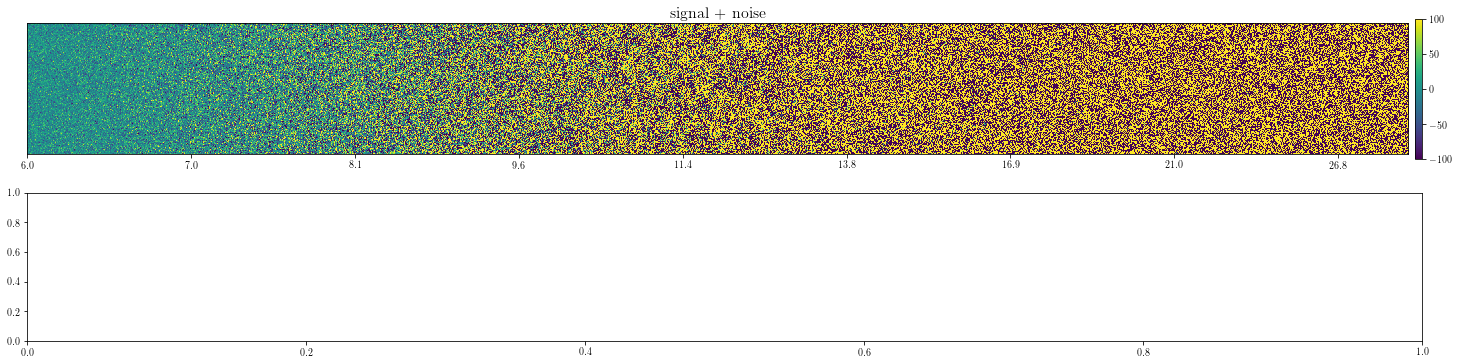

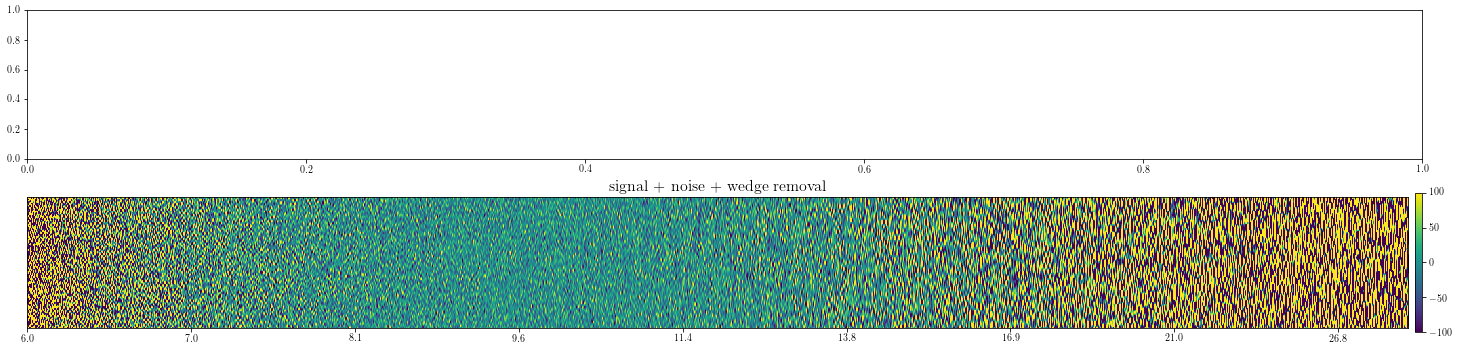

In [46]:
plotting_wedge(Box_final)

In [ ]:
#creating W filter
def W_total():
    k_perp = np.fft.fftfreq(Box.shape[0], d=1.5)
    k_parallel = np.fft.fftfreq(Box.shape[-1], d=1.5)
    k_cube = np.meshgrid(k_perp, k_perp, k_parallel)
    W_tot = []
    for i, z in enumerate(redshifts_mean):
        print(i, end = ' ')
        W_tot.append(W(k_cube, z).astype(np.float32))
    return W_tot

In [ ]:
W_tot = W_total()

In [47]:
Box.shape

(200, 200, 2107)